<a href="https://colab.research.google.com/github/mohamedshouaib/iti/blob/main/iti/DeepLearning%20/MLP/fashion_mnist_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import random
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)


# Data

In [ ]:

transform = transforms.ToTensor()

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


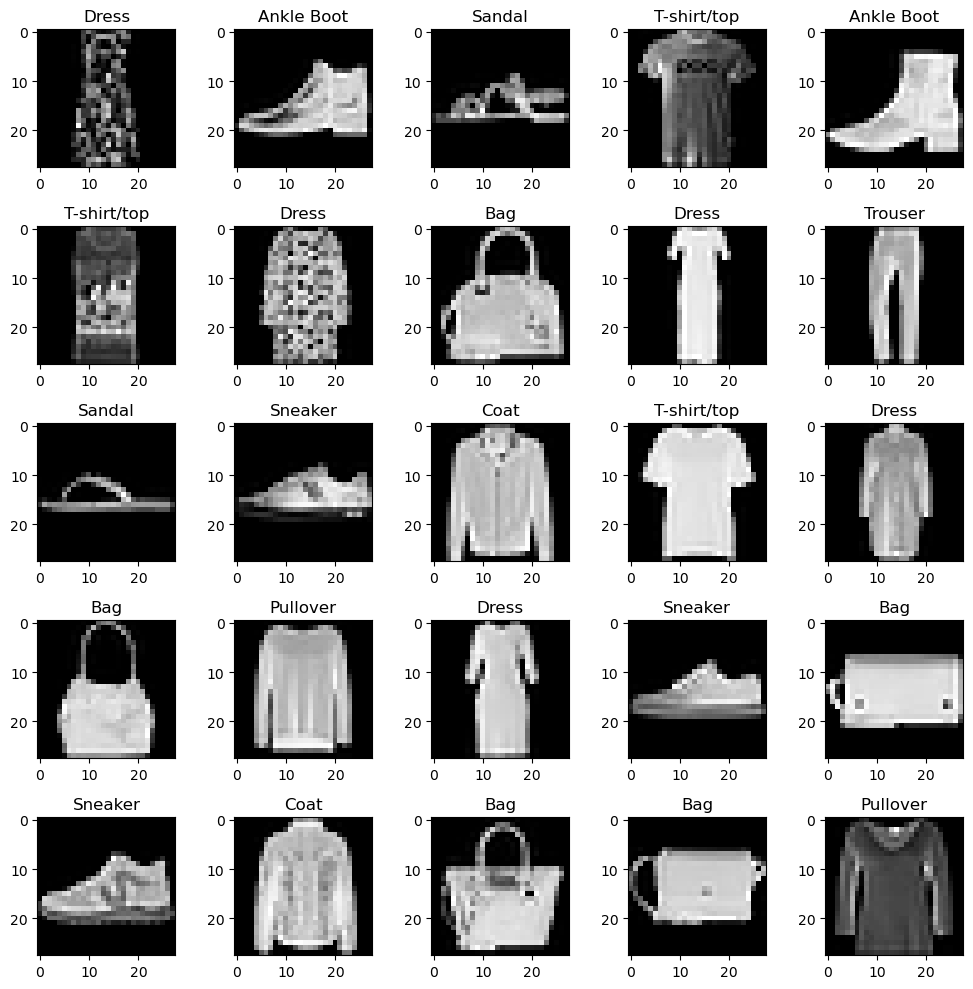

In [ ]:
batch = next(iter(training_loader))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(*batch)):
    if i > 24:
        break
    plt.subplot(5, 5, i + 1)
    plt.imshow(image[0], cmap="gray")
    plt.title(classes[label])

plt.tight_layout()

# Exercise

You are required to train an MLP on the Fashion MNIST dataset. For this task, you must define the following:

* The objective function
* The model architecture
* The optimizer
* The training loop

You will train three MLP models, each with different hyperparameters. You must vary at least two of the following aspects between the models:

* Number of layers
* Number of neurons
* Activation function
* Optimizer


## Deliverables
* The complete code
* Learning curves for the three MLP models
* Table summarizing the changes in the hyperparameters and the performance of the models on the train and test sets.
* A write-up analyzing how your choices impacted the results.

## Define loss Function, Model Architecture, and Optimizer

In [ ]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the model architecture
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, activation_function):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(activation_function())

        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
            layers.append(activation_function())

        layers.append(nn.Linear(hidden_layers[-1], num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define the optimizer
def get_optimizer(optimizer_name, model, learning_rate):
    if optimizer_name == 'SGD':
        return optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'Adam':
        return optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

## Define the Training Loop

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.view(images.size(0), -1)  # Flatten the images
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)  # Flatten the images
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

## Train Three MLP Models with Different Hyperparameters

In [ ]:
# Define the hyperparameters for the three models
models = [
    {
        'hidden_layers': [128, 64],
        'activation_function': nn.ReLU,
        'optimizer_name': 'SGD',
        'learning_rate': 0.01
    },
    {
        'hidden_layers': [256, 128, 64],
        'activation_function': nn.Tanh,
        'optimizer_name': 'Adam',
        'learning_rate': 0.001
    },
    {
        'hidden_layers': [512, 256],
        'activation_function': nn.ReLU,
        'optimizer_name': 'Adam',
        'learning_rate': 0.0005
    }
]

# Train the models
results = []
for i, model_params in enumerate(models):
    model = MLP(input_size=28*28, hidden_layers=model_params['hidden_layers'], num_classes=10, activation_function=model_params['activation_function'])
    optimizer = get_optimizer(model_params['optimizer_name'], model, model_params['learning_rate'])
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, training_loader, validation_loader, criterion, optimizer, num_epochs=15)
    results.append({
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    })

Epoch [1/15], Train Loss: 1.1158, Train Acc: 63.70%, Val Loss: 0.6931, Val Acc: 75.73%
Epoch [2/15], Train Loss: 0.5974, Train Acc: 79.06%, Val Loss: 0.5646, Val Acc: 79.87%
Epoch [3/15], Train Loss: 0.5119, Train Acc: 82.14%, Val Loss: 0.5116, Val Acc: 81.85%
Epoch [4/15], Train Loss: 0.4725, Train Acc: 83.36%, Val Loss: 0.4852, Val Acc: 82.62%
Epoch [5/15], Train Loss: 0.4470, Train Acc: 84.39%, Val Loss: 0.4606, Val Acc: 83.67%
Epoch [6/15], Train Loss: 0.4285, Train Acc: 84.91%, Val Loss: 0.4726, Val Acc: 83.37%
Epoch [7/15], Train Loss: 0.4123, Train Acc: 85.55%, Val Loss: 0.4347, Val Acc: 84.78%
Epoch [8/15], Train Loss: 0.3998, Train Acc: 85.96%, Val Loss: 0.4274, Val Acc: 84.77%
Epoch [9/15], Train Loss: 0.3878, Train Acc: 86.39%, Val Loss: 0.4321, Val Acc: 84.82%
Epoch [10/15], Train Loss: 0.3787, Train Acc: 86.76%, Val Loss: 0.4026, Val Acc: 85.86%
Epoch [11/15], Train Loss: 0.3686, Train Acc: 87.01%, Val Loss: 0.3966, Val Acc: 86.14%
Epoch [12/15], Train Loss: 0.3611, Train 

## Learning Curves

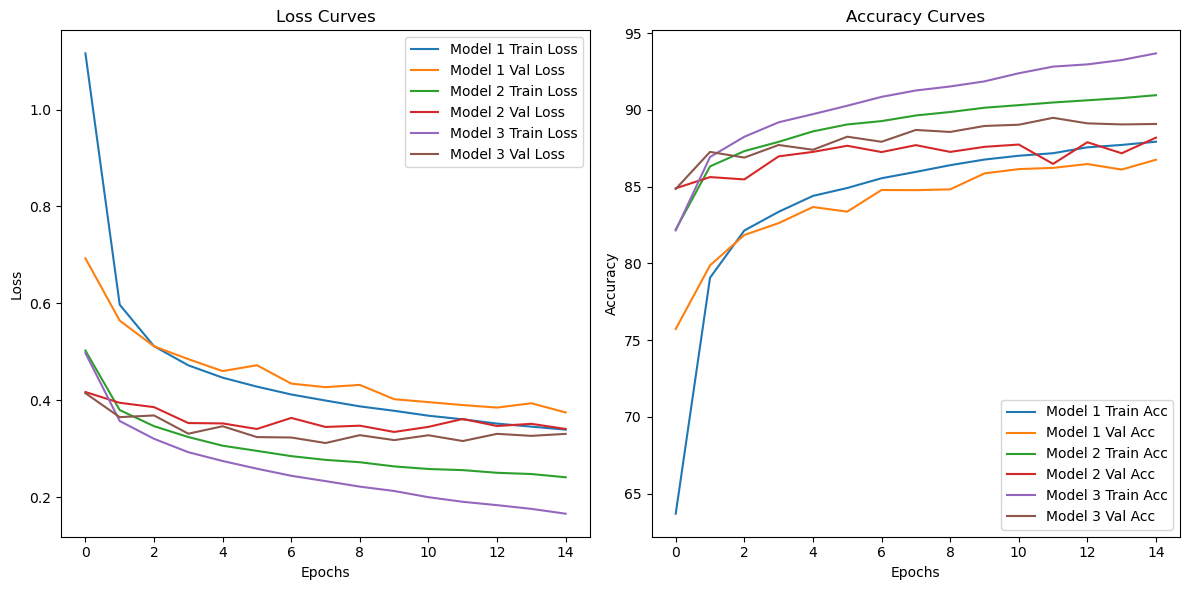

In [ ]:
plt.figure(figsize=(12, 6))
for i, result in enumerate(results):
    plt.subplot(1, 2, 1)
    plt.plot(result['train_losses'], label=f'Model {i+1} Train Loss')
    plt.plot(result['val_losses'], label=f'Model {i+1} Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(result['train_accuracies'], label=f'Model {i+1} Train Acc')
    plt.plot(result['val_accuracies'], label=f'Model {i+1} Val Acc')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

## Summarize Hyperparameters and Performance

In [ ]:
import pandas as pd

summary = []
for i, model_params in enumerate(models):
    summary.append({
        'Model': i+1,
        'Hidden Layers': model_params['hidden_layers'],
        'Activation Function': model_params['activation_function'].__name__,
        'Optimizer': model_params['optimizer_name'],
        'Learning Rate': model_params['learning_rate'],
        'Train Loss': results[i]['train_losses'][-1],
        'Val Loss': results[i]['val_losses'][-1],
        'Train Accuracy': results[i]['train_accuracies'][-1],
        'Val Accuracy': results[i]['val_accuracies'][-1]
    })

df = pd.DataFrame(summary)
print(df)

   Model   Hidden Layers Activation Function Optimizer  Learning Rate  \
0      1       [128, 64]                ReLU       SGD         0.0100   
1      2  [256, 128, 64]                Tanh      Adam         0.0010   
2      3      [512, 256]                ReLU      Adam         0.0005   

   Train Loss  Val Loss  Train Accuracy  Val Accuracy  
0    0.339842  0.375261       87.925000         86.75  
1    0.241602  0.341220       90.953333         88.19  
2    0.166472  0.331073       93.678333         89.08  


In [ ]:
# The choice of hyperparameters, including the number of layers, activation function, optimizer, and learning rate,
# significantly impacts the performance of MLP models on the Fashion MNIST dataset.